                         QuantReg Regression Results                          
Dep. Variable:                profile   Pseudo R-squared:               0.5912
Model:                       QuantReg   Bandwidth:                       4.941
Method:                 Least Squares   Sparsity:                        8.064
Date:                Thu, 20 Jun 2019   No. Observations:                   25
Time:                        17:38:52   Df Residuals:                       23
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.3059      1.574      1.465      0.156      -0.950       5.562
plate_phill     0.0463      0.005      8.649      0.000       0.035       0.057
      q         a         b        lb        ub
0  0.05  2.188076 -0.002294       NaN       NaN
1  0.15  0.753246  0.043290    

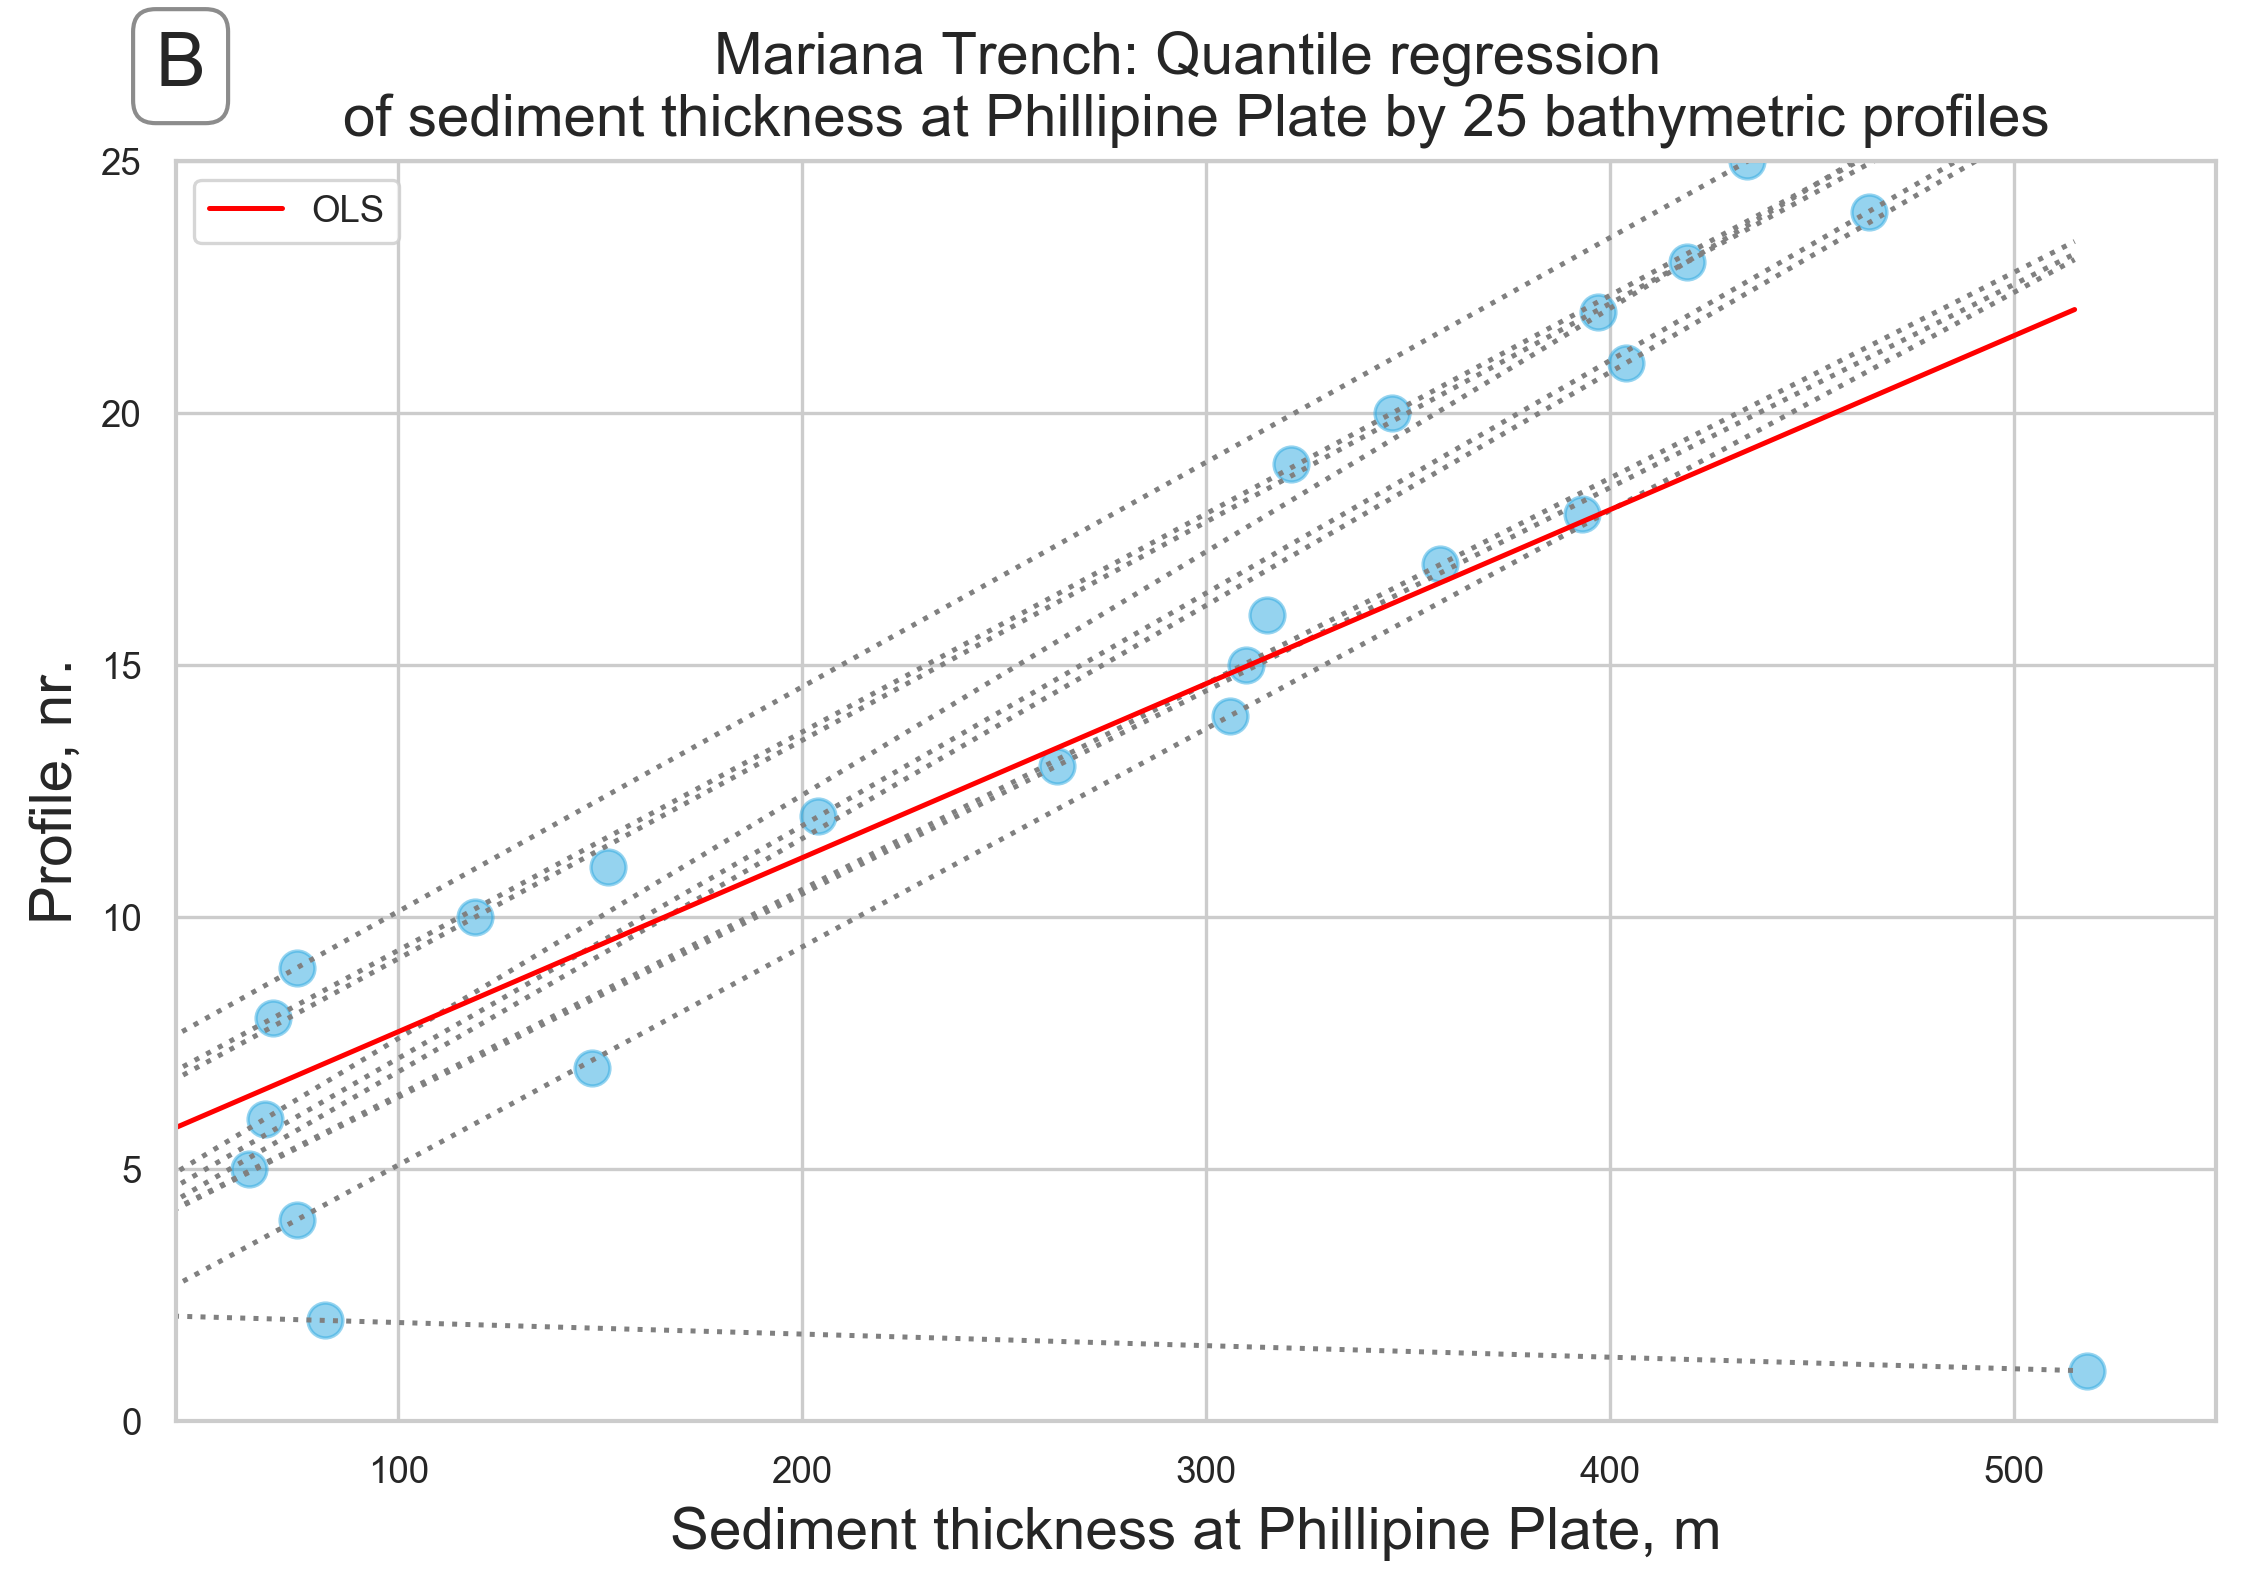

In [4]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import print_function
%matplotlib inline
import os
import patsy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('paper')

os.chdir('/Users/pauline/Documents/Python')
data = pd.read_csv("Tab-Morph.csv")

# Least Absolute Deviation
mod = smf.quantreg('profile ~ plate_phill', data)
res = mod.fit(q=.5)
print(res.summary())

# Placing the quantile regression results in a Pandas DataFrame, and the OLS results in a dictionary
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['plate_phill']] + \
            res.conf_int().loc['plate_phill'].tolist()
    
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])

ols = smf.ols('profile ~ plate_phill', data).fit()
ols_ci = ols.conf_int().loc['plate_phill'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['plate_phill'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

# plotting
x = np.arange(data.plate_phill.min(), data.plate_phill.max(), 5)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
bbox_props = dict(boxstyle='round, pad=0.3', fc='w',
                  edgecolor='grey', linewidth=1, alpha=0.9)
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.plate_phill, data.profile, alpha=.5, c='#2ca9e1', s=70)
ax.set_xlim((45, 550))
ax.set_ylim((0, 25))
legend = ax.legend()
ax.set_xlabel('Sediment thickness at Phillipine Plate, m', fontsize=14)
ax.set_ylabel('Profile, nr.', fontsize=14)
plt.title("Mariana Trench: Quantile regression \nof sediment thickness at Phillipine Plate by 25 bathymetric profiles", 
          fontsize=14)
plt.annotate('B', xy=(-0.01, 1.06), xycoords="axes fraction", 
             fontsize=18, bbox=bbox_props)

# visualize and save
plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15,
                    left=0.10, right=0.95,
                    hspace=0.25, wspace=0.35
                    )
fig.savefig('plot_QRb.png', dpi=300)
plt.show()